# Purpose
The Purpose of this Notebook is to consolidate categorical features from `immoscout_cleaned_lat_lon_fixed_v9.csv` in one column each.

# Summary

| Feature       | Complete Data found in/with | 
| ------------- | --------------------------- |
| Municipality  | Read from external list |
| Zip Code | RegEx `address` with `(\d{4})`, set to RegEx `plz:(\d+)` from `location_parsed` where RegEx from `address` does not match external list  | 
| Canton | Read from external list | 
| Street        | RegEx `^Strasse:(.+?) plz` from `location_parsed` and substitute where NA with RegEx `(.+), \d{4}` from `address`, which needs to cleanup `-` and `à` entries. Drop 3874 and set street from 12363 to `Rte de la Jorette` |
| Street Number | RegEx `^.+ (\d.+)` from above prepared `street` |
| Availability  | Join `Availability_merged` and `detail_responsive#available_from` |

In [29]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [30]:
# import DataFarme
df = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/immoscout_cleaned_lat_lon_fixed_v9.csv", low_memory=False)

# Address

We discovered that the following columns containing information about the address of an object:
- `Commune`
- `Comune`
- `Gemeinde`
- `Municipality`
- `Municipality_merged`
- `detail_responvice#municipality`
- `address`
- `Locality`
- `location`
- `location_parsed`
- `table`
- `details_structured`
- `Zip`

In [31]:
# selecting the columns Municipality and location, Municipality_merged, location_parsed, address, details_structured, Locality
cols_address = ['Municipality', 'Gemeinde', 'Commune', 'Comune', 'detail_responsive#municipality', 'Municipality_merged', 'location', 'location_parsed', 'address', 'Locality', 'Zip']
df_address = df.loc[:, cols_address]

In [32]:
df_address

,Municipality,Gemeinde,Commune,Comune,detail_responsive#municipality,Municipality_merged,location,location_parsed,address,Locality,Zip
0,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"5023 Biberstein, AG",Strasse: plz:5023 Stadt: Biberstein Kanton: AG,"5023 Biberstein, AG",Biberstein,5023
1,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"Buhldenstrasse 8d5023 Biberstein, AG",Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Buhldenstrasse 8d, 5023 Biberstein, AG",Biberstein,5023
2,NaN,NaN,NaN,NaN,Küttigen,NaN,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Aarau,5000
3,Biberstein,NaN,NaN,NaN,NaN,Biberstein,"Buhaldenstrasse 8A5023 Biberstein, AG",Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...,"Buhaldenstrasse 8A, 5023 Biberstein, AG",Biberstein,5023
4,Küttigen,NaN,NaN,NaN,NaN,Küttigen,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Rombach,5022
...,...,...,...,...,...,...,...,...,...,...,...
13373,Uster,NaN,NaN,NaN,NaN,Uster,"Tägerackerstrasse 138610 Uster, ZH",Strasse:Tägerackerstrasse 13 plz:8610 Stadt: ...,"Tägerackerstrasse 13, 8610 Uster, ZH",Uster,8610
13374,Volketswil,NaN,NaN,NaN,NaN,Volketswil,"8604 Volketswil, ZH",Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,"8604 Volketswil, ZH",Volketswil,8604
13375,Seuzach,NaN,NaN,NaN,NaN,Seuzach,"8472 Seuzach, ZH",Strasse: plz:8472 Stadt: Seuzach Kanton: ZH,"8472 Seuzach, ZH",Hettlingen,8442
13376,Zell (ZH),NaN,NaN,NaN,NaN,Zell (ZH),"Vordere Bähntalstrasse 18483 Kollbrunn, ZH",Strasse:Vordere Bähntalstrasse 1 plz:8483 Sta...,"Vordere Bähntalstrasse 1, 8483 Kollbrunn, ZH",Weisslingen,8484


## Municipality

We also learned that the following columns contain information about the municipality:
- `Commune`
- `Comune`
- `Gemeinde`
- `Municipality`
- `Municipality_merged`
- `detail_responvice#municipality`
- `address`
- `Locality`
- `location`
- `location_parsed`
- `table`
- `details_structured`

In [33]:
# prepare separate dataframe to handle municipality data
df_municipality = df_address.copy()
df_municipality['from_table'] = df['table'].str.extract("Municipality.+?rJZBK####>(.+?)<\/td>")
df_municipality['from_details_structured'] = df['details_structured'].str.extract("'Municipality': '(.+?)'")
df_municipality['from_location'] = df_municipality['location'].str.extract(r"\d (.+?),")
df_municipality['from_location_parsed'] = df_municipality['location_parsed'].str.extract(r"Stadt: (.+?) K")
df_municipality.drop(['location_parsed', 'location', 'Zip'], axis=1, inplace=True)

### NA Heatmap
The following heatmap shows the missing values of the selected data and can therefore give some good insight on where the complete data can be found.

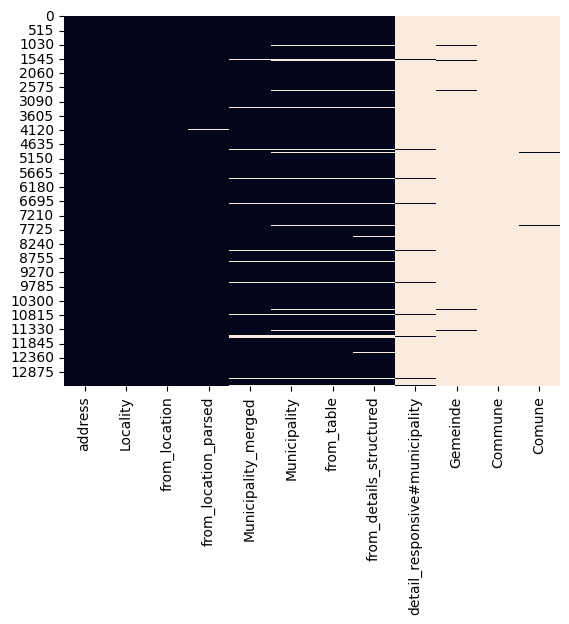

In [34]:
# Sort columns by number of non-null values
df_municipality = df_municipality.reindex(df_municipality.count().sort_values(ascending=False).index, axis=1)
# Create isna heatmap
sns.heatmap(df_municipality.isna(), cbar=False)
plt.show()

In [35]:
# Select rows where from_table and from_details_structured are not equal
df_municipality[df_municipality['from_table'].fillna('') != df_municipality['from_details_structured'].fillna('')]

,address,Locality,from_location,from_location_parsed,Municipality_merged,Municipality,from_table,from_details_structured,detail_responsive#municipality,Gemeinde,Commune,Comune
4,"5022 Rombach, AG",Rombach,Rombach,Rombach,Küttigen,Küttigen,K&#252;ttigen,Küttigen,NaN,NaN,NaN,NaN
43,"5022 Rombach, AG",Rombach,Rombach,Rombach,Küttigen,Küttigen,K&#252;ttigen,Küttigen,NaN,NaN,NaN,NaN
47,"5022 Rombach, AG",Rombach,Rombach,Rombach,Küttigen,Küttigen,K&#252;ttigen,Küttigen,NaN,NaN,NaN,NaN
51,"Bibersteinerstrasse 80, 5022 Rombach, AG",Rombach,Rombach,Rombach,Küttigen,Küttigen,K&#252;ttigen,Küttigen,NaN,NaN,NaN,NaN
55,"Waldweg, 5022 Rombach, AG",Küttigen,Rombach,Rombach,Küttigen,Küttigen,K&#252;ttigen,Küttigen,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13291,"Pfaffhausen, 8118 Pfaffhausen, ZH",Pfaffhausen,Pfaffhausen,Pfaffhausen,Fällanden,Fällanden,F&#228;llanden,Fällanden,NaN,NaN,NaN,NaN
13293,"Im Langwil, 8044 Gockhausen, ZH",Wallisellen,Gockhausen,Gockhausen,"Dübendorf, Kreis 7 (Zurich)","Dübendorf, Kreis 7 (Zurich)","D&#252;bendorf, Kreis 7 (Zurich)","Dübendorf, Kreis 7 (Zurich)",NaN,NaN,NaN,NaN
13295,"Pfaffensteinstrasse 35, 8118 Pfaffhausen, ZH",Pfaffhausen,Pfaffhausen,Pfaffhausen,Fällanden,Fällanden,F&#228;llanden,Fällanden,NaN,NaN,NaN,NaN
13297,"Zürich, 8044 Zürich, ZH",Winterthur,Zürich,Zürich,"Zürich, Kreis 6 (Zurich)","Zürich, Kreis 6 (Zurich)","Z&#252;rich, Kreis 6 (Zurich)","Zürich, Kreis 6 (Zurich)",NaN,NaN,NaN,NaN


The above table shows all observations where `from_table` is not equal to `from_details_structured`. The data extracted from `table` (column `from_table`) suffers from encoding issues and seems to not provide more information than other columns so we discard it. Also it looks like there's some inconsistency in the data. 

In [36]:
df_municipality.drop('from_table', axis=1, inplace=True)

In [37]:
#  Select rows where Municipality and from_details_structured are not equal
df_municipality[df_municipality['Municipality'].fillna('') != df_municipality['from_details_structured'].fillna('')]

,address,Locality,from_location,from_location_parsed,Municipality_merged,Municipality,from_details_structured,detail_responsive#municipality,Gemeinde,Commune,Comune
7908,"Via Privata 5, 6919 Carabietta, TI",Collina d'Oro,Carabietta,Carabietta,Collina d Oro,Collina d Oro,NaN,NaN,NaN,NaN,NaN
7913,"6919 Carabietta, TI",Collina d'Oro,Carabietta,Carabietta,Collina d Oro,Collina d Oro,NaN,NaN,NaN,NaN,NaN
7918,"6919 Carabietta, TI",Collina d'Oro,Carabietta,Carabietta,Collina d Oro,Collina d Oro,NaN,NaN,NaN,NaN,NaN
7923,"6919 Carabietta, TI",Collina d'Oro,Carabietta,Carabietta,Collina d Oro,Collina d Oro,NaN,NaN,NaN,NaN,NaN
7928,"6919 Carabietta, TI",Collina d'Oro,Carabietta,Carabietta,Collina d Oro,Collina d Oro,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12217,"1873 Les Crosets, VS",Val-d'Illiez,Les Crosets,Les Crosets,Val-d Illiez,Val-d Illiez,NaN,NaN,NaN,NaN,NaN
12219,"1873 Val-d'Illiez, VS",Val-d'Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,NaN,NaN,NaN,NaN,NaN
12221,"1873 Val-d'Illiez, VS",Val-d'Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,NaN,NaN,NaN,NaN,NaN
12223,"Val-d'Illiez, 1873 Val-d'Illiez, VS",Val-d'Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,Val-d Illiez,NaN,NaN,NaN,NaN,NaN


The above output shows observations where `Municipality` is not equal to `from_details_structured` and suggests that `Gemeinde`, `Commune`, `Comune`, `detail_responsive#municipality` and `from_details_structured` do not contain the most information.

In [38]:
df_municipality.drop(['Gemeinde', 'from_details_structured', 'Commune', 'Comune'], axis=1, inplace=True)

In [39]:
# Select rows where Municipality and Locality are not equal
df_municipality[df_municipality['Municipality'].fillna('') != df_municipality['Locality'].fillna('')]

,address,Locality,from_location,from_location_parsed,Municipality_merged,Municipality,detail_responsive#municipality
2,"5022 Rombach, AG",Aarau,Rombach,Rombach,NaN,NaN,Küttigen
4,"5022 Rombach, AG",Rombach,Rombach,Rombach,Küttigen,Küttigen,NaN
5,"Buchhalde 36, 5018 Erlinsbach, AG",Erlinsbach,Erlinsbach,Erlinsbach,Erlinsbach (AG),Erlinsbach (AG),NaN
8,"Siebenmatten 49, 5032 Aarau Rohr, AG",Aarau Rohr,Aarau Rohr,Aarau Rohr,Aarau,Aarau,NaN
9,"5018 Erlinsbach, AG",Erlinsbach,Erlinsbach,Erlinsbach,Erlinsbach (AG),Erlinsbach (AG),NaN
...,...,...,...,...,...,...,...
13359,"8604 Volketswil, ZH",Volketswil,Volketswil,Volketswil,NaN,NaN,Volketswil
13363,"Zum Hölzli 17, 8405 Winterthur, ZH",Winterthur,Winterthur,Winterthur,NaN,NaN,Winterthur
13366,"8604 Volketswil, ZH",Volketswil,Volketswil,Volketswil,Volketswil,NaN,NaN
13375,"8472 Seuzach, ZH",Hettlingen,Seuzach,Seuzach,Seuzach,Seuzach,NaN


This above table shows observations where `Municipality` is not equal to `Locality`. It looks like `Municipality` is missing information that `Locality` and other columns provide and still that there's conflicting information concerning the municipality.

In [40]:
df_municipality[(df_municipality['from_location'].notna()) & (df_municipality['from_location_parsed'].isna())]

,address,Locality,from_location,from_location_parsed,Municipality_merged,Municipality,detail_responsive#municipality
3874,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,Winterthur,COLLONGES SOUS SALEVE1256 Troinex,NaN,Troinex,Troinex,NaN
4096,"7514 Sils/Segl Maria, GR",Winterthur,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl,NaN
4097,"7514 Sils/Segl Maria, GR",Winterthur,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl,NaN
4098,"7514 Sils/Segl Maria, GR",Winterthur,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl,NaN
4226,"Via Brutg 23, 7032 Laax GR 2, GR",Winterthur,Laax GR 2,NaN,Laax,Laax,NaN
4229,"Via Brutg 23, 7032 Laax GR 2, GR",Winterthur,Laax GR 2,NaN,Laax,Laax,NaN
4232,"Via Cuolm Liung 30, 7032 Laax GR 2, GR",Winterthur,Laax GR 2,NaN,Laax,Laax,NaN
4235,"7032 Laax GR 2, GR",Winterthur,Laax GR 2,NaN,Laax,Laax,NaN
10234,"1000 Lausanne 26, VD",Winterthur,Lausanne 26,NaN,Lausanne,Lausanne,NaN
10237,"1000 Lausanne 26, VD",Winterthur,Lausanne 26,NaN,Lausanne,Lausanne,NaN


Inspecting this table which shows rows where `from_location` is not `na` and `from_location_parsed` is suggests that `address` is a duplicate of `location`. Also `Locality` seems to contain incorrect information. `from_location_parsed` does not contain the biggest dataset.

In [41]:
df_municipality.drop(['address', 'Locality'], axis=1, inplace=True)

In [42]:
# Select rows where from_location and from_location_parsed are not equal
df_municipality[df_municipality['from_location'].fillna('') != df_municipality['from_location_parsed'].fillna('')]

,from_location,from_location_parsed,Municipality_merged,Municipality,detail_responsive#municipality
13,Buchs AG,Buchs,Buchs (AG),Buchs (AG),NaN
17,Buchs AG,Buchs,Buchs (AG),Buchs (AG),NaN
19,Buchs AG,Buchs,Buchs (AG),Buchs (AG),NaN
27,Buchs AG,Buchs,Buchs (AG),Buchs (AG),NaN
29,Buchs AG,Buchs,Buchs (AG),Buchs (AG),NaN
...,...,...,...,...,...
13226,Erlenbach ZH,Erlenbach,Erlenbach (ZH),Erlenbach (ZH),NaN
13228,Erlenbach ZH,Erlenbach,Erlenbach (ZH),Erlenbach (ZH),NaN
13230,Erlenbach ZH,Erlenbach,Erlenbach (ZH),Erlenbach (ZH),NaN
13232,Erlenbach ZH,Erlenbach,Erlenbach (ZH),Erlenbach (ZH),NaN


This table shows rows where `from_location` is not equal to `from_location_parsed`.  
Going forward we investigate if there are rows where `detail_responsive#municipality` contains information where `from_location_parsed` does not. 

In [43]:
df_municipality[df_municipality['detail_responsive#municipality'].notna() & df_municipality['from_location_parsed'].isna()]

,from_location,from_location_parsed,Municipality_merged,Municipality,detail_responsive#municipality


It does not, so we can drop it.

In [44]:
df_municipality.drop('detail_responsive#municipality', axis=1, inplace=True)

In [45]:
df_municipality[df_municipality['Municipality'].notna() & df_municipality['from_location_parsed'].isna()]

,from_location,from_location_parsed,Municipality_merged,Municipality
3874,COLLONGES SOUS SALEVE1256 Troinex,NaN,Troinex,Troinex
4096,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl
4097,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl
4098,Sils/Segl Maria,NaN,Sils im Engadin/Segl,Sils im Engadin/Segl
4226,Laax GR 2,NaN,Laax,Laax
4229,Laax GR 2,NaN,Laax,Laax
4232,Laax GR 2,NaN,Laax,Laax
4235,Laax GR 2,NaN,Laax,Laax
10234,Lausanne 26,NaN,Lausanne,Lausanne
10237,Lausanne 26,NaN,Lausanne,Lausanne


This table shows observations where `Municipality` is not `na` and `from_location_parsed` is. There seems to be a gap of information that can be filled.

In [46]:
# set from_location_parsed to Municipality where Municipality is notna and from_location_parsed isna
df_municipality.loc[df_municipality['Municipality'].notna() & df_municipality['from_location_parsed'].isna(), 'from_location_parsed'] = df_municipality['Municipality']

With that gap filled we verify that `from_location_parsed` now contains the complete dataset.

In [47]:
# display where Municipality is notna and from_location_parsed isna
df_municipality[df_municipality['Municipality'].notna() & df_municipality['from_location_parsed'].isna()]

,from_location,from_location_parsed,Municipality_merged,Municipality


In [48]:
# select where from_location_parsed isna
df_municipality[df_municipality['from_location_parsed'].isna()]

,from_location,from_location_parsed,Municipality_merged,Municipality


In [49]:
df_municipality.drop(['Municipality', 'Municipality_merged', 'from_location'], axis=1, inplace=True)

In [50]:
df_municipality.rename(columns={'from_location_parsed': 'municipality'}, inplace=True)
df_municipality.describe()

,municipality
count,13378
unique,2079
top,Lausanne
freq,128


## PLZ

We found that the following columns contain information on the postal code that are easily extractable:
- `address`
- `location_parsed`
- `Zip`  

Other columns don't clearly separate the postal code from other information which makes it hard to extract, so we ignored them. 

In [51]:
# Prepare dataframe to handle postal code data
cols_plz = ['address', 'location_parsed', 'Zip']
df_plz = df.loc[:, cols_plz]
df_plz['from_address'] = df_plz['address'].str.extract(r"(\d{4})")
df_plz['from_location_parsed'] = df_plz['location_parsed'].str.extract(r"plz:(\d+)")
df_plz.drop(['address', 'location_parsed'], axis=1, inplace=True)

## NA Heatmap

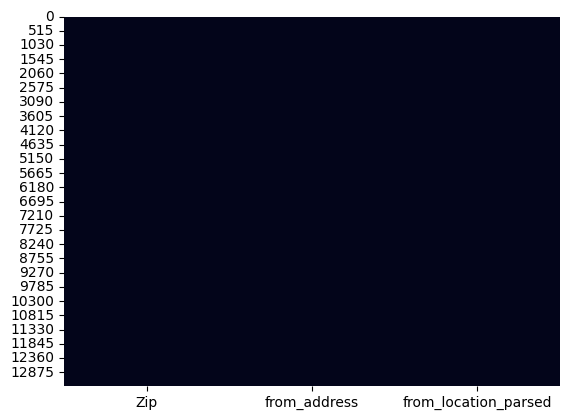

In [52]:
# Sort columns by number of non-null values
df_plz = df_plz.reindex(df_plz.count().sort_values(ascending=False).index, axis=1)
# Create isna heatmap
sns.heatmap(df_plz.isna(), cbar=False)
plt.show()

In [53]:
df_plz.count()

Zip                     13378
from_address            13378
from_location_parsed    13360
dtype: int64

It looks like these rows contain pretty much complete data. 

In [54]:
# Add municipality column to df_plz and show rows where there are na values
df_plz['municipality'] = df_municipality['municipality'].copy()
df_plz[df_plz.isna().any(axis=1)]

,Zip,from_address,from_location_parsed,municipality
3874,8405,7416,NaN,Troinex
4096,8405,7514,NaN,Sils im Engadin/Segl
4097,8405,7514,NaN,Sils im Engadin/Segl
4098,8405,7514,NaN,Sils im Engadin/Segl
4226,8405,7032,NaN,Laax
4229,8405,7032,NaN,Laax
4232,8405,7032,NaN,Laax
4235,8405,7032,NaN,Laax
10234,8405,1000,NaN,Lausanne
10237,8405,1000,NaN,Lausanne


The above table shows where `na` values occur. Even though `from_location_parsed` could be the more complete column due to ease of access there is information available in `from_address` where `from_location_parsed` is `na` and this lead us to believe that there's a need to verify the extracted data. 

In [55]:
df_xlsx_plz = pd.read_excel("../../eda/utils/plz.xlsx", sheet_name='Blatt1')

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [56]:
df_xlsx_plz.drop(['Kanton', 'Canton', 'Cantone', 'Land', 'Pays', 'Paese'], axis=1, inplace=True)
df_xlsx_plz.rename(columns={df_xlsx_plz.columns[0]: 'plz', df_xlsx_plz.columns[1]: 'municipality', df_xlsx_plz.columns[2]: 'kanton'}, inplace=True)

In [57]:
df_xlsx_plz

,plz,municipality,kanton
0,1000,Lausanne,VD
1,1003,Lausanne,VD
2,1004,Lausanne,VD
3,1005,Lausanne,VD
4,1006,Lausanne,VD
...,...,...,...
4115,9652,Neu St. Johann,SG
4116,9655,Stein SG,SG
4117,9656,Alt St. Johann,SG
4118,9657,Unterwasser,SG


This list is provided by [postleitzahlenschweiz.ch](https://postleitzahlenschweiz.ch/tabelle/) and contains all postal codes and their municipalities. With this list we see that one postal code can be assigned to multiple municipalities. 

In [58]:
# Show if rows from 'from_address' are found in 'df_xlsx_plz'
df_plz['from_address'] = df_plz['from_address'].astype(int)
df_plz['from_address'].isin(df_xlsx_plz['plz']).value_counts()

True     13374
False        4
Name: from_address, dtype: int64

The above statement shows that there are 4 postal codes in `from_address` that are not present in the list provided by postleitzahlenschweiz.ch.

In [59]:
df_plz[~df_plz['from_address'].isin(df_xlsx_plz['plz'])]

,Zip,from_address,from_location_parsed,municipality
2217,3822,1488,3823,Wengen
3104,1630,2007,1630,Bulle
5428,9472,3695,9472,Grabs
11805,1988,1850,1988,Les Collons


These postal codes in `from_address` mismatch the data in other columns, which can be found in the postal code list. We therefore substitute those entries with the values from `from_location_parsed`. 

In [60]:
# Substitute values in 'from_address' with values from 'from_location_parsed' where 'from_address' is not in 'df_xlsx_plz'
df_plz.loc[~df_plz['from_address'].isin(df_xlsx_plz['plz']), 'from_address'] = df_plz.loc[~df_plz['from_address'].isin(df_xlsx_plz['plz']), 'from_location_parsed'].values
df_plz['from_address'] = df_plz['from_address'].astype(int)

In [61]:
df_plz[~df_plz['from_address'].isin(df_xlsx_plz['plz'])]

,Zip,from_address,from_location_parsed,municipality


And we can now verify that all values in `from_address` are also values present in the postal code list.

In [62]:
# Show rows from 'from_address' that are not equal to 'Zip'
df_plz[df_plz['from_address'] != df_plz['Zip']]

,Zip,from_address,from_location_parsed,municipality
2,5000,5022,5022,Rombach
7,5000,5004,5004,Aarau
10,5000,5004,5004,Aarau
31,5417,5301,5301,Siggenthal Station
35,5000,5004,5004,Aarau
...,...,...,...,...
13320,8604,8606,8606,Nänikon
13328,8400,8406,8406,Winterthur
13337,8400,8408,8408,Winterthur
13375,8442,8472,8472,Seuzach


The values in `Zip` seem to originate from a different source than the other columns. 

In [63]:
# Show rows from 'from_address' that are not equal to 'from_location_parsed'
df_plz[df_plz['from_address'] != df_plz['from_location_parsed'].fillna(0).astype(int)]

,Zip,from_address,from_location_parsed,municipality
3874,8405,7416,NaN,Troinex
4096,8405,7514,NaN,Sils im Engadin/Segl
4097,8405,7514,NaN,Sils im Engadin/Segl
4098,8405,7514,NaN,Sils im Engadin/Segl
4226,8405,7032,NaN,Laax
4229,8405,7032,NaN,Laax
4232,8405,7032,NaN,Laax
4235,8405,7032,NaN,Laax
5637,9642,2806,9642,Ebnat-Kappel
10234,8405,1000,NaN,Lausanne


And there are still clear mismatches between the three postal code columns. To provide a solid foundation for any models we want to ensure that the data is as consistent as possible which is why we substitute the municipality name selected so far with names from the postal code list. But since there are sometimes multiple municipalities for one postal code, we cannot uniquely match the names this way. The other way around also won't work because of character mismatches.  

Municipalities sharing a postal code are located very close to each other and often share administration and other services, which is why we choose the chance to select the wrong name to a verified postal code. 

In [64]:
df_xlsx_plz.drop_duplicates(subset='plz', inplace=True)

In [65]:
# Add municipality and kanton columns from dff_xlsx_plz to df_plz
df_plz['municipality_from_xlsx'] = df_plz['from_address'].map(df_xlsx_plz.set_index('plz')['municipality'])
df_plz['kanton_from_xlsx'] = df_plz['from_address'].map(df_xlsx_plz.set_index('plz')['kanton'])

In [66]:
# Show rows from 'from_address' that are not equal to 'from_location_parsed' again
df_plz[df_plz['from_address'] != df_plz['from_location_parsed'].fillna(0).astype(int)]

,Zip,from_address,from_location_parsed,municipality,municipality_from_xlsx,kanton_from_xlsx
3874,8405,7416,NaN,Troinex,Almens,GR
4096,8405,7514,NaN,Sils im Engadin/Segl,Fex,GR
4097,8405,7514,NaN,Sils im Engadin/Segl,Fex,GR
4098,8405,7514,NaN,Sils im Engadin/Segl,Fex,GR
4226,8405,7032,NaN,Laax,Laax GR 2,GR
4229,8405,7032,NaN,Laax,Laax GR 2,GR
4232,8405,7032,NaN,Laax,Laax GR 2,GR
4235,8405,7032,NaN,Laax,Laax GR 2,GR
5637,9642,2806,9642,Ebnat-Kappel,Mettembert,JU
10234,8405,1000,NaN,Lausanne,Lausanne,VD


Upon manual inspection of these mismatches we can verify that the municipalities in `municipality_from_xlsx` are located right next to the one in `municipality` and since it's consistent with the postal codes in `from_address` we'll use this information going forward. 

In [67]:
# Clean up df_plz
df_plz['plz'] = df_plz['from_address'].copy()
df_plz['municipality'] = df_plz['municipality_from_xlsx'].copy()
df_plz['kanton'] = df_plz['kanton_from_xlsx'].copy()
df_plz.drop(['from_address', 'from_location_parsed', 'municipality_from_xlsx', 'kanton_from_xlsx', 'Zip'], axis=1, inplace=True)

In [68]:
df_plz

,municipality,plz,kanton
0,Biberstein,5023,AG
1,Biberstein,5023,AG
2,Rombach,5022,AG
3,Biberstein,5023,AG
4,Rombach,5022,AG
...,...,...,...
13373,Uster,8610,ZH
13374,Volketswil,8604,ZH
13375,Seuzach,8472,ZH
13376,Kollbrunn,8483,ZH


## Street
Information on the street of an object can be found in the following columns:
- `address`
- `location`
- `location_parsed`
- `details_structured` (contains `location`)

In [69]:
# Prepare dataframe to handle street data
cols_street = ['address', 'location_parsed', 'location']
df_street = df.loc[:, cols_street]
df_street['from_address'] = df_street['address'].str.extract(r"(.+), \d{4}")
df_street['from_location_parsed'] = df_street['location_parsed'].str.extract(r'^Strasse:(.+?) plz').replace(' ', np.nan)
df_street['from_location'] = df_street['location'].str.extract(r"(.+)\d{4} ")

df_street.drop(['address', 'location_parsed', 'location'], axis=1, inplace=True)

In [70]:
df_street

,from_address,from_location_parsed,from_location
0,NaN,NaN,NaN
1,Buhldenstrasse 8d,Buhldenstrasse 8d,Buhldenstrasse 8d
2,NaN,NaN,NaN
3,Buhaldenstrasse 8A,Buhaldenstrasse 8A,Buhaldenstrasse 8A
4,NaN,NaN,NaN
...,...,...,...
13373,Tägerackerstrasse 13,Tägerackerstrasse 13,Tägerackerstrasse 13
13374,NaN,NaN,NaN
13375,NaN,NaN,NaN
13376,Vordere Bähntalstrasse 1,Vordere Bähntalstrasse 1,Vordere Bähntalstrasse 1


Data can be extracted more accurately from `location_parsed` since it is clearly structured. Nevertheless there could be more data contained in other columns.

In [71]:
# Show where columns are na but 'from_address' is not na
df_street[df_street.isna().any(axis=1) & df_street['from_address'].notna()]

,from_address,from_location_parsed,from_location
1365,-,NaN,-
1368,-,NaN,-
3035,Centré,NaN,Centré
3403,Allée du Verger.,NaN,Allée du Verger.
3874,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
4226,Via Brutg 23,NaN,Via Brutg 23
4229,Via Brutg 23,NaN,Via Brutg 23
4232,Via Cuolm Liung 30,NaN,Via Cuolm Liung 30
4377,-,NaN,-
4474,-,NaN,-


The RegEx to extract street data from `address`, `location` and `location_parsed` seems to work ok but we find that `location` and `address` contains street data where `location_parsed` does not, so we substitute information in `from_location_parsed` for these instances.

In [72]:
# Get index of rows where columns are na but 'from_address' is not na
list_index = df_street[df_street.isna().any(axis=1) & df_street['from_address'].notna()].index

In [73]:
# Cleanup 'from_address' and 'from_location_parsed' columns
df_street.loc[df_street['from_address'] == '-', 'from_address'] = np.nan
df_street.loc[df_street['from_location_parsed'] == '-', 'from_address'] = np.nan

In [74]:
# Set from_location_parsed to from_address where from_location_parsed is null
df_street.loc[df_street['from_location_parsed'].isna(), 'from_location_parsed'] = df_street.loc[df_street['from_location_parsed'].isna(), 'from_address'].values

In [75]:
# Print rows where columns are na but 'from_address' is not na again
df_street.iloc[list_index]

,from_address,from_location_parsed,from_location
1365,NaN,NaN,-
1368,NaN,NaN,-
3035,Centré,Centré,Centré
3403,Allée du Verger.,Allée du Verger.,Allée du Verger.
3874,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...
4226,Via Brutg 23,Via Brutg 23,Via Brutg 23
4229,Via Brutg 23,Via Brutg 23,Via Brutg 23
4232,Via Cuolm Liung 30,Via Cuolm Liung 30,Via Cuolm Liung 30
4377,NaN,NaN,-
4474,NaN,NaN,-


The data now looks cleaner, but we've introduced some errors. Also the column 3874 contains data on a property in france, which is not really part of the sampled population, so we drop it. 

In [76]:
df_street.drop(3874, inplace=True)

In [77]:
# Clean up 'from_address' and 'from_location_parsed' columns
df_street.loc[df_street['from_address'] == 'à', 'from_address'] = np.nan
df_street.loc[df_street['from_location_parsed'] == 'à', 'from_address'] = np.nan

We also noticed that «Résidence "Le Cleuset"» is no street name. With a quick Google search we find that this property is on the street «Rte de la Jorette».

In [78]:
df_street.iloc[12363]['from_location_parsed'] = 'Rte de la Jorette'

In [79]:
df_street

,from_address,from_location_parsed,from_location
0,NaN,NaN,NaN
1,Buhldenstrasse 8d,Buhldenstrasse 8d,Buhldenstrasse 8d
2,NaN,NaN,NaN
3,Buhaldenstrasse 8A,Buhaldenstrasse 8A,Buhaldenstrasse 8A
4,NaN,NaN,NaN
...,...,...,...
13373,Tägerackerstrasse 13,Tägerackerstrasse 13,Tägerackerstrasse 13
13374,NaN,NaN,NaN
13375,NaN,NaN,NaN
13376,Vordere Bähntalstrasse 1,Vordere Bähntalstrasse 1,Vordere Bähntalstrasse 1


In [80]:
# Clean up df_street
df_street["street_nr"] = df_street['from_location_parsed'].str.extract(r'^.+ (\d.+)')
df_street["street"] = df_street['from_location_parsed'].str.extract(r'^(.+?) \d')
df_street["street"] = df_street['street'].str.rstrip()

df_street.drop(['from_address', 'from_location_parsed', 'from_location'], axis=1, inplace=True)

In [81]:
df_street

,street_nr,street
0,NaN,NaN
1,8d,Buhldenstrasse
2,NaN,NaN
3,8A,Buhaldenstrasse
4,NaN,NaN
...,...,...
13373,13,Tägerackerstrasse
13374,NaN,NaN
13375,NaN,NaN
13376,NaN,Vordere Bähntalstrasse


# Availability
Data on the availability of a property can be found in the following columns:

- `Availability`
- `Availability_merged`
- `Disponibilità`
- `Disponibilité`
- `Verfügbarkeit`
- `detail_responsive#available_from`
- `details_structured`
- `table`

In [82]:
# Prepare dataframe to handle availability data
cols_availability = ['Availability', 'Verfügbarkeit', 'Disponibilité', 'Disponibilità', 'detail_responsive#available_from',  'Availability_merged']
df_availability = df.loc[:, cols_availability]
df_availability['from_details_structured'] = df['details_structured'].str.extract(r"'Availability': '(.+?)'")

Like with columns we analysed in [this](./3-daw_quantitative.html) notebook we find that the column `Availability_merged` consists of the data from `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`:

In [83]:
df_availability.iloc[:, 0:5].count().cumsum() == df_availability.iloc[:, 5].count()

Availability                        False
Verfügbarkeit                       False
Disponibilité                       False
Disponibilità                        True
detail_responsive#available_from    False
dtype: bool

## NA Heatmap

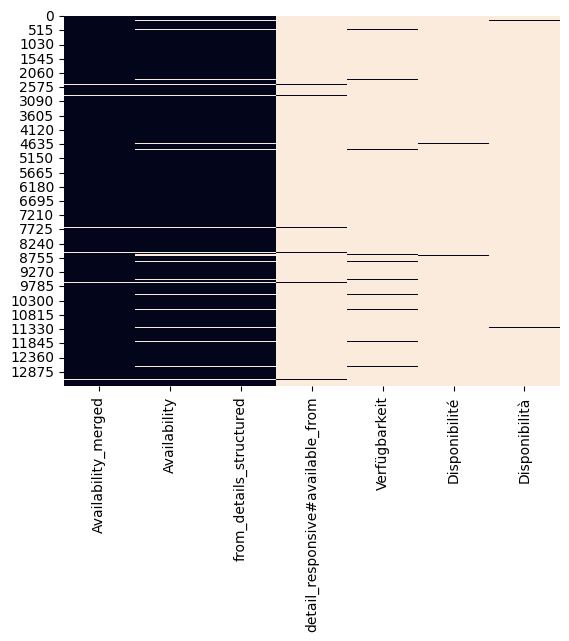

In [84]:
# Sort columns by number of non-null values
df_availability = df_availability.reindex(df_availability.count().sort_values(ascending=False).index, axis=1)
# Create isna heatmap
sns.heatmap(df_availability.isna(), cbar=False)
plt.show()

In [85]:
# Merge columns `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`
df_availability['availability'] = df_availability[cols_availability[0]].fillna('') + \
  (df_availability[cols_availability[1]]).fillna('') + \
  (df_availability[cols_availability[2]]).fillna('') + \
  (df_availability[cols_availability[3]]).fillna('')
# compare 'availability' with 'Availability_merged'
(df_availability['availability'] == df_availability[cols_availability[5]].fillna('')).sum() == df.shape[0]

True

We can confirm, that the column `Availability_merged` contains all information from the columns `Availability`, `Verfügbarkeit`, `Disponibilité` and `Disponibilità`. Merging `detail_responsive#available_from` adds more data.

In [86]:
# Merge columns `availability` and `detail_responsive#available_from`
df_availability['availability'] = df_availability[cols_availability[5]].fillna('') + \
  (df_availability[cols_availability[4]]).fillna('')

df_availability['availability'] = df_availability['availability'].replace('', np.nan)

df_availability['availability'].count()

13378

And with that we've got complete data on the availability.

In [87]:
# Clean up df_availability
df_availability.drop(['Availability', 'Verfügbarkeit', 'Disponibilité', 'Disponibilità', 'detail_responsive#available_from', 'Availability_merged'], axis=1, inplace=True)
df_availability

,from_details_structured,availability
0,On request,On request
1,On request,On request
2,NaN,Immediately
3,On request,On request
4,On request,On request
...,...,...
13373,On request,On request
13374,On request,On request
13375,On request,On request
13376,Immediately,Immediately
